In [5]:
!pip install mediapipe

import mediapipe as mp
import os
import cv2
from tqdm import tqdm
from random import sample
from PIL import Image
import pickle
import time
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset

from sklearn.metrics import accuracy_score
from sklearn import svm, metrics, preprocessing

In [6]:
with open(r"/kaggle/input/dgw-faces-annotation/dgw_train_faces_annotation", "rb") as input_file:
    train_annotation = pickle.load(input_file)
    
with open(r"/kaggle/input/dgw-faces-annotation/dgw_val_faces_annotation", "rb") as input_file:
    val_annotation = pickle.load(input_file)
    
with open(r"/kaggle/input/dgw-faces-annotation/dgw_test_faces_annotation", "rb") as input_file:
    test_annotation = pickle.load(input_file)

In [4]:
train_annotation['Кадр'][0]

'/kaggle/input/driver-gaze-in-the-wild/dgw_faces/dgw_faces/train_faces/7/Sub56_vid1_frame186.png'

In [98]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
drawing_spec = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)

right_eye_indexes = [33, 133, 145, 159] # порядок важен
left_eye_indexes = [263, 362, 374, 386] # порядок важен

def extract_eyes(annotation, save_path):
    for img_path in annotation['Кадр']:
        image = cv2.imread(img_path)

        img_h, img_w, _ = image.shape

        results = face_mesh.process(image)

        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        left_eye_2d = []
        right_eye_2d = []

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # у каждого кадра берем только нужные точки
                for idx, landmark in enumerate(face_landmarks.landmark):

                    if idx in right_eye_indexes:
                        x, y = int(landmark.x * img_w), int(landmark.y * img_h)
                        right_eye_2d.append([x, y])

                    if idx in left_eye_indexes:
                        x, y = int(landmark.x * img_w), int(landmark.y * img_h)
                        left_eye_2d.append([x, y])

        else:
            print('Лицевые точки не найдены', img_path)

In [69]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
drawing_spec = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)

right_eye_indexes = [33, 133, 145, 159] # порядок важен
left_eye_indexes = [263, 362, 374, 386] # порядок важен

image = cv2.imread('/kaggle/input/driver-gaze-in-the-wild/dgw/dgw/train/1/Sub186_1_frame47.png')

# image = cv2.imread('/kaggle/input/driver-gaze-in-the-wild/dgw/dgw/train/7/Sub185_1_frame260.png')

img_h, img_w, _ = image.shape

results = face_mesh.process(image)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
left_eye_2d = []
right_eye_2d = []

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # у каждого кадра берем только нужные точки
        for idx, landmark in enumerate(face_landmarks.landmark):

            if idx in right_eye_indexes:
                x, y = int(landmark.x * img_w), int(landmark.y * img_h)
                right_eye_2d.append([x, y])

            if idx in left_eye_indexes:
                x, y = int(landmark.x * img_w), int(landmark.y * img_h)
                left_eye_2d.append([x, y])
                
        for dot in right_eye_2d:
            cv2.circle(image, dot, 3, (0,0,255), -1)
        
        for dot in left_eye_2d:
            cv2.circle(image, dot, 3, (0,0,255), -1)

else:
    print('Лицевые точки не найдены', img_path)

In [70]:
# измерение ширины и высоты левого глаза
l_eye_w = left_eye_2d[0][0] - left_eye_2d[1][0]
l_eye_h = left_eye_2d[2][1] - left_eye_2d[3][1]

# получение координат bbox'а левого глаза
l_left_up = (left_eye_2d[1][0] - int(l_eye_w * 0.5), left_eye_2d[3][1] - int(l_eye_h * 2))
l_right_bottom = (left_eye_2d[0][0] + int(l_eye_w * 0.5), left_eye_2d[2][1] + int(l_eye_h * 2))

# измерение ширины и высоты правого глаза
r_eye_w = right_eye_2d[1][0] - right_eye_2d[0][0]
r_eye_h = right_eye_2d[2][1] - right_eye_2d[3][1]

# получение координат bbox'а правого глаза
r_left_up = (right_eye_2d[0][0] - int(r_eye_w * 0.5), right_eye_2d[3][1] - int(r_eye_h * 2))
r_right_bottom = (right_eye_2d[1][0] + int(r_eye_w * 0.5), right_eye_2d[2][1] + int(r_eye_h * 2))

In [71]:
left_eye_2d

[[849, 380], [797, 373], [823, 380], [825, 372]]

In [72]:
right_eye_2d

[[675, 360], [726, 365], [701, 366], [699, 357]]

Text(0.5, 1.0, 'Image with bbox')

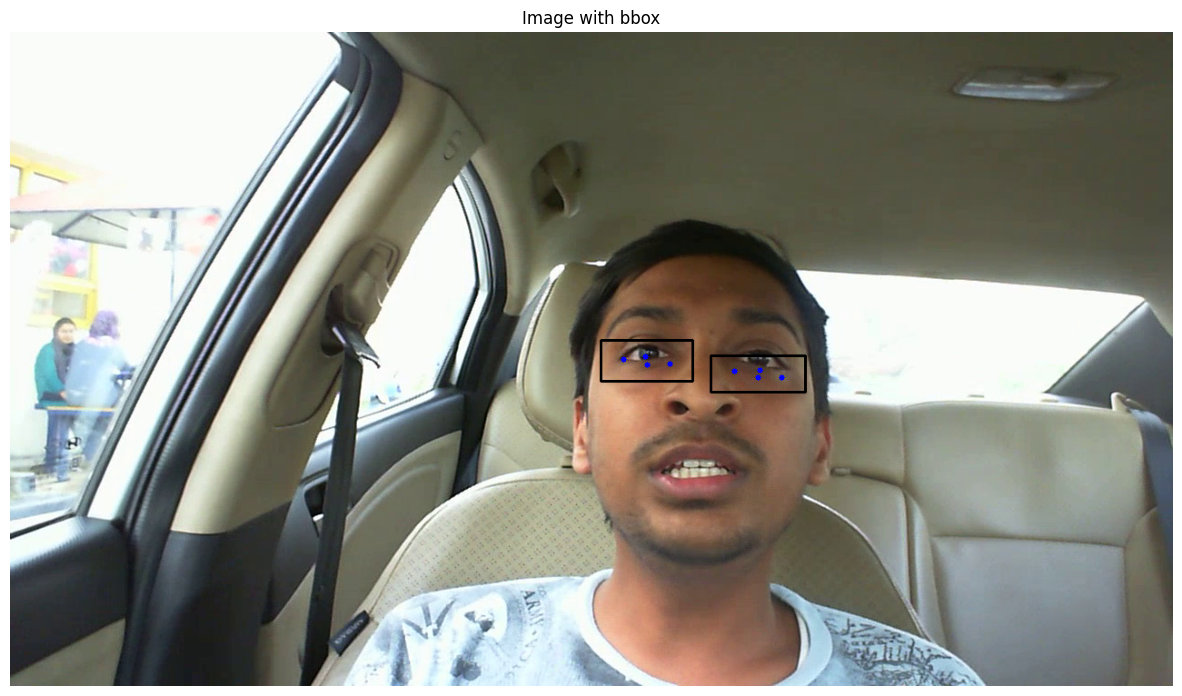

In [73]:
image = cv2.rectangle(image, l_left_up, l_right_bottom,(0,0,0), 2)
image = cv2.rectangle(image, r_left_up, r_right_bottom,(0,0,0), 2)

plt.figure(figsize = [15,10])
plt.imshow(image); plt.axis('off'); plt.title("Image with bbox")

### OpenFace eye extraction

In [103]:
from tqdm import tqdm

In [176]:
def extract_eyes(annotation, features_path, out_dir):
    if not os.path.exists(out_dir + '/left'):
        os.makedirs(out_dir + '/left')
    if not os.path.exists(out_dir + '/right'):
        os.makedirs(out_dir + '/right')
        
    not_found_files = []
    for filename in tqdm(annotation['Кадр']):
        # print(features_path + '/' + filename.split('/')[-1].split('.')[0] + '.csv')
        path_to_csv = features_path + '/' + filename.split('/')[-1].split('.')[0] + '.csv'
        if os.path.exists(path_to_csv):
            frame_features = pd.read_csv(path_to_csv) # r'test_faces_path.csv'
            frame_features.columns = [col[1:] if i != 0 else col for i, col in enumerate(frame_features.columns)]
            frame_features = frame_features.sort_values(by=['confidence'], ascending=False).reset_index(drop = True)
            frame_features = frame_features[frame_features.index == 0]

            filename = filename.replace('_faces', '')
            # print(filename)
            frame = cv2.imread(filename)

            face_points = [(int(frame_features['eye_lmk_x_8'].values), int(frame_features['eye_lmk_y_8'].values)),
                            (int(frame_features['eye_lmk_x_14'].values), int(frame_features['eye_lmk_y_14'].values)),
                            (int(frame_features['eye_lmk_x_11'].values), int(frame_features['eye_lmk_y_11'].values)),
                            (int(frame_features['eye_lmk_x_17'].values), int(frame_features['eye_lmk_y_17'].values)),
                            (int(frame_features['eye_lmk_x_42'].values), int(frame_features['eye_lmk_y_42'].values)),
                            (int(frame_features['eye_lmk_x_36'].values), int(frame_features['eye_lmk_y_36'].values)),
                            (int(frame_features['eye_lmk_x_39'].values), int(frame_features['eye_lmk_y_39'].values)),
                            (int(frame_features['eye_lmk_x_45'].values), int(frame_features['eye_lmk_y_45'].values))]

            # for i, dot in enumerate(face_points):
                # print(i+1, dot)
                # cv2.circle(frame, dot, 3, (0,0,255), -1)
                # cv2.putText(frame, str(i+1), dot, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
        
            # plt.figure(figsize = [15,10])
            # plt.imshow(frame); plt.axis('off'); plt.title("Image with bbox")

            # измерение ширины и высоты левого глаза
            l_eye_w = face_points[4][0] - face_points[5][0]
            l_eye_h = face_points[7][1] - face_points[6][1]

            # получение координат bbox'а левого глаза
            l_left_up = (face_points[5][0] - int(l_eye_w * 0.5), face_points[6][1] - int(l_eye_h * 2))
            l_right_bottom = (face_points[4][0] + int(l_eye_w * 0.5), face_points[7][1] + int(l_eye_h * 2))

            # измерение ширины и высоты правого глаза
            r_eye_w = face_points[1][0] - face_points[0][0]
            r_eye_h = face_points[3][1] - face_points[2][1]

            # получение координат bbox'а правого глаза
            r_left_up = (face_points[0][0] - int(r_eye_w * 0.5), face_points[2][1] - int(r_eye_h * 2))
            r_right_bottom = (face_points[1][0] + int(r_eye_w * 0.5), face_points[3][1] + int(r_eye_h * 2))

            # cv2.rectangle(frame, l_left_up, l_right_bottom,(0,0,0), 2)
            # cv2.rectangle(frame, r_left_up, r_right_bottom,(0,0,0), 2)

            # plt.figure(figsize = [15,10])
            # plt.imshow(frame); plt.axis('off'); plt.title("Image with bbox")
            # print(l_left_up, l_right_bottom)
            left_eye_img = frame[l_left_up[1]:l_right_bottom[1], l_left_up[0]:l_right_bottom[0]]
            right_eye_img = frame[r_left_up[1]:r_right_bottom[1], r_left_up[0]:r_right_bottom[0]]
            
            # print(out_dir + '/left/' + filename.split('/')[-1].split('.')[0] + '.jpg')
            if len(left_eye_img) != 0 and len(right_eye_img) != 0:
                cv2.imwrite(out_dir + '/left/' + filename.split('/')[-1].split('.')[0] + '.jpg', left_eye_img)
                cv2.imwrite(out_dir + '/right/' + filename.split('/')[-1].split('.')[0] + '.jpg', right_eye_img)
            
            # plt.figure(figsize = [15,10])
            # plt.imshow(left_eye_img); plt.axis('off'); plt.title("Image with bbox")
            
            # plt.figure(figsize = [15,10])
            # plt.imshow(right_eye_img); plt.axis('off'); plt.title("Image with bbox")

        else:
            not_found_files.append(path_to_csv)
        
        with open(r'/kaggle/working/not_found_csvs_' + out_dir.split('/')[-1].split('_')[0], 'wb') as handle:
            pickle.dump(not_found_files, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [177]:
train_features_path = '/kaggle/input/dgw-openface-features/train'
val_features_path = '/kaggle/input/dgw-openface-features/val'
test_features_path = '/kaggle/input/dgw-openface-features/test'

In [178]:
extract_eyes(train_annotation, train_features_path, '/kaggle/working/train_eyes')

100%|██████████| 21763/21763 [25:57<00:00, 13.97it/s]


In [ ]:
extract_eyes(val_annotation, val_features_path, '/kaggle/working/val_eyes')

 48%|████▊     | 4758/9994 [06:12<07:46, 11.22it/s]

In [ ]:
extract_eyes(test_annotation, test_features_path, '/kaggle/working/test_eyes')

In [36]:
train_annotation['Кадр'][0].split('/')[-1].split('.')[0]

'Sub56_vid1_frame186'

In [175]:
import shutil
shutil.rmtree("/kaggle/working/train_eyes")

In [185]:
import os
os.chdir(r'/kaggle/working')

!tar -czf test_eyes.tar.gz test_eyes

from IPython.display import FileLink

FileLink(r'test_eyes.tar.gz')

/kaggle/working/test_eyes.tar.gz

In [ ]:
train_faces_dir = '/kaggle/input/driver-gaze-in-the-wild/dgw_faces/dgw_faces/train_faces'
val_faces_dir = '/kaggle/input/driver-gaze-in-the-wild/dgw_faces/dgw_faces/val_faces'